# Pneumonia Classifier

In [3]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import timm
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import transforms as T, datasets
from torchvision.utils import make_grid

from torchsummary import summary

/Users/waranyoo/Desktop/ai-medicine-projects/pneumonia-classifier/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Helper
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [5]:
class conf:
    epochs = 1
    lr = 0.001
    batch_size = 16
    model_name = "tf_efficientnet_b4_ns"
    img_size = 224
    DATA_DIR = "data"
    TEST = "test"
    VAL = "val"
    TRAIN = "train"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("On device: {}".format(device))

On device: cpu


In [6]:
# Transform training dataset
transform_train = T.Compose([
    T.Resize(size = (conf.img_size, conf.img_size)),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transform validation dataset
transform_val = T.Compose([
    T.Resize(size = (conf.img_size, conf.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transform test dataset
transform_test = T.Compose([
    T.Resize(size = (conf.img_size, conf.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Loading dataset
path_train = os.path.join(conf.DATA_DIR, conf.TRAIN)
set_train = datasets.ImageFolder(path_train, transform = transform_train)

path_val = os.path.join(conf.DATA_DIR, conf.VAL)
set_val = datasets.ImageFolder(path_val, transform = transform_val)

path_test = os.path.join(conf.DATA_DIR, conf.TEST)
set_test = datasets.ImageFolder(path_test, transform = transform_test)

Train:  5216
Val:  16
Test:  624


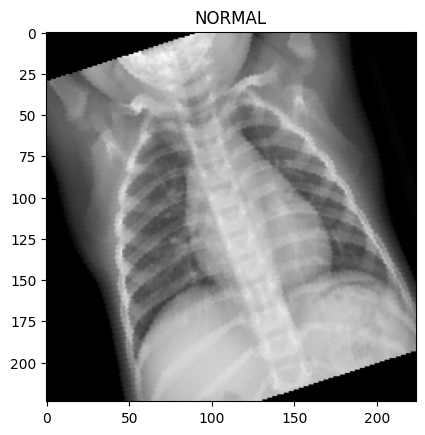

In [8]:
# Print number of images in each dataset
print("Train: ", len(set_train))
print("Val: ", len(set_val))
print("Test: ", len(set_test))

# Show sample image(s)
class_name = ['NORMAL','PNEUMONIA']
image, label = set_train[2]
show_image(image, class_name[label])

In [9]:
# Load Dataset into Batches
load_train = DataLoader(set_train, batch_size = conf.batch_size, shuffle = True)
load_val = DataLoader(set_val, batch_size = conf.batch_size, shuffle = True)
load_test = DataLoader(set_test, batch_size = conf.batch_size, shuffle = True)

In [10]:
# Number of batches and total examples of trainloader
print('Number of batches in Trainloader:', len(load_train))
print('Number of total examples:', len(load_train.dataset))

Number of batches in Trainloader: 326
Number of total examples: 5216


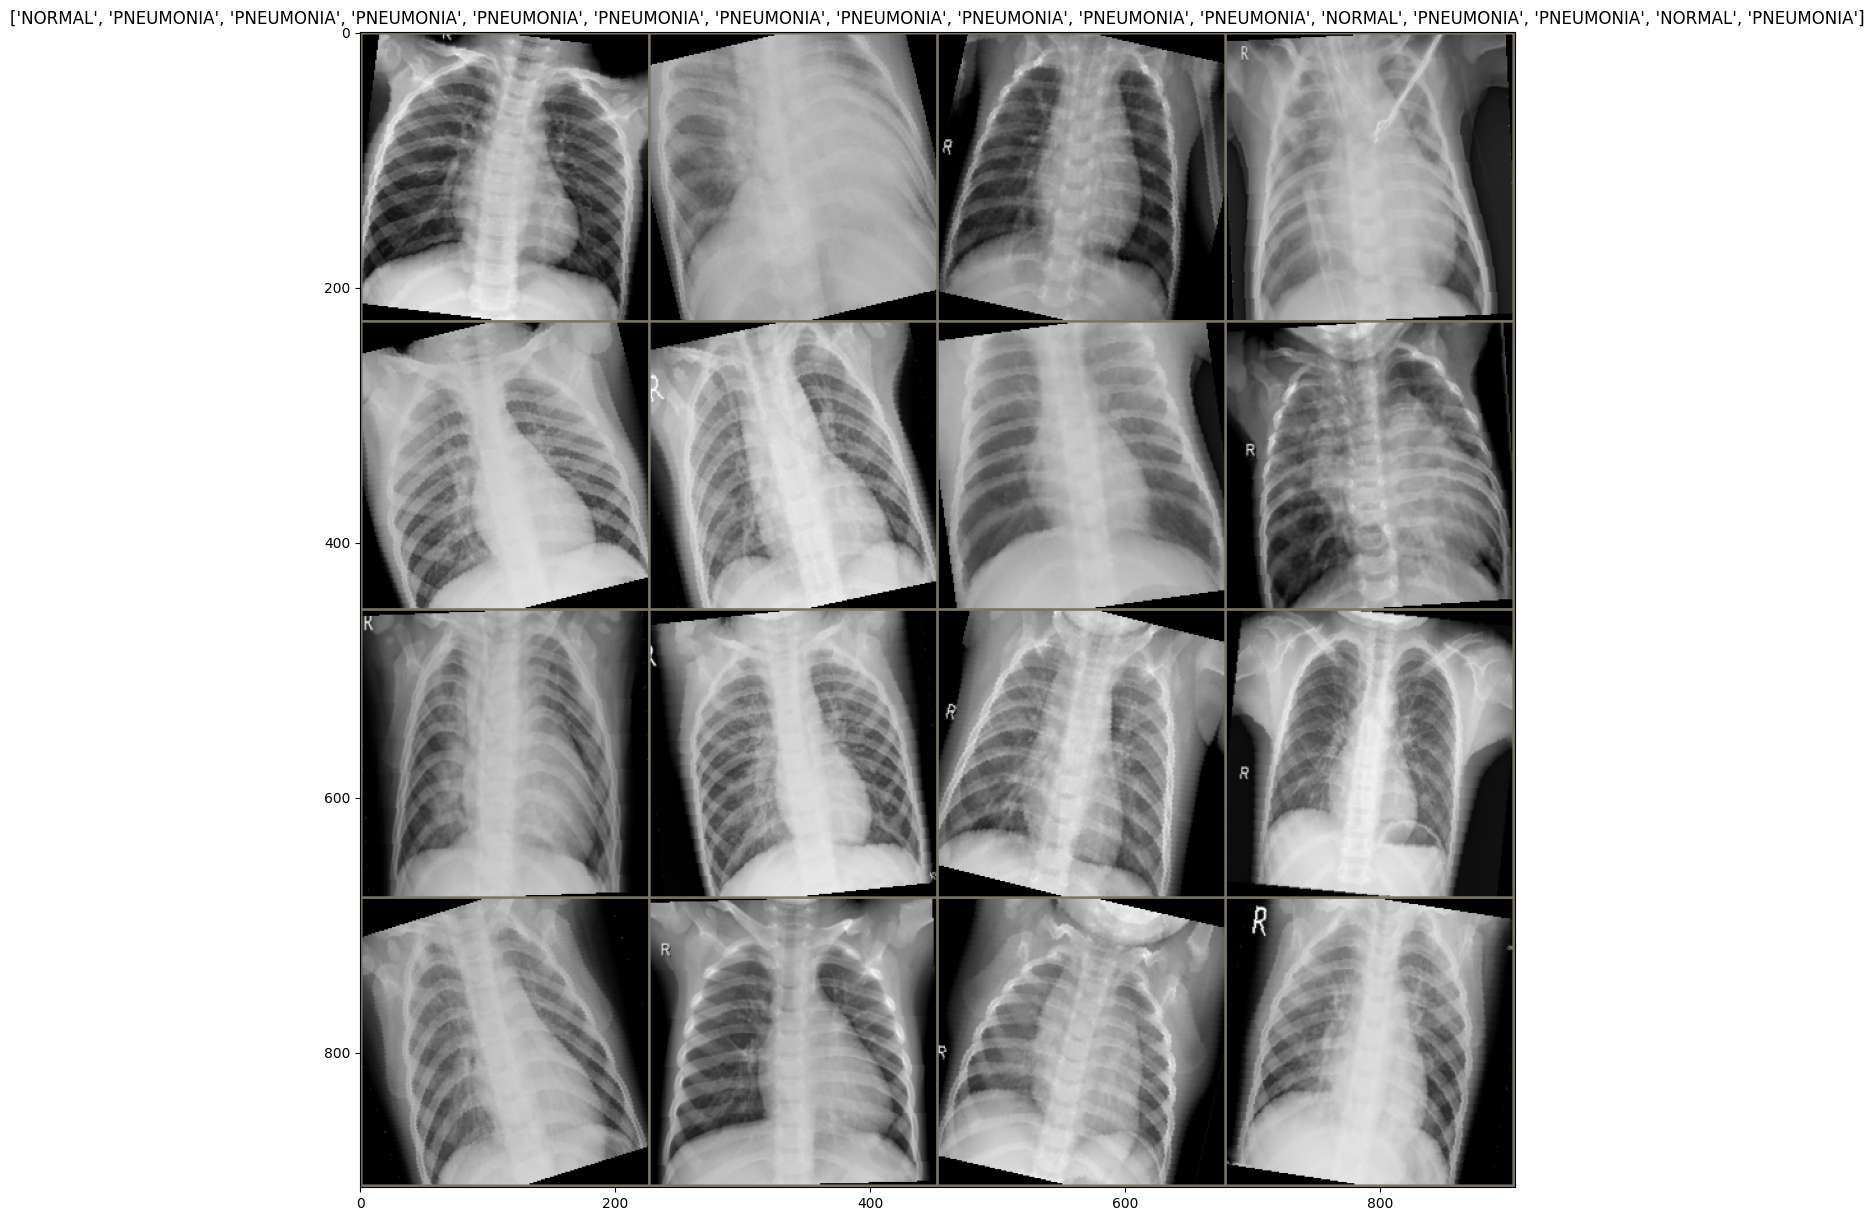

In [11]:
# Dataiter
dataiter = iter(load_train)
images, labels = next(dataiter)
out = make_grid(images, nrow = 4)
show_grid(out, title = [class_name[x] for x in labels])

In [12]:
# Using EfficientNet Model
model = timm.create_model(conf.model_name, pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(in_features = 1792, out_features = 625),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features = 625, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 2)
)

summary(model, input_size = (3,224,224))

/Users/waranyoo/Desktop/ai-medicine-projects/pneumonia-classifier/venv/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

In [13]:
# Trainer
class pneumo_train():
    def __init__(self, criterion, optimizer, scheduler):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_batch_loop(self, model, load_train):
        train_acc = 0.0
        train_loss = 0.0
        for images, labels in tqdm(load_train):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
        return train_acc / len(load_train), train_loss / len(load_train)

    def valid_batch_loop(self, model, load_val):
        val_acc = 0.0
        val_loss = 0.0
        for images, labels in tqdm(load_val):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)
            val_loss += loss.item()
            val_acc += accuracy(logits, labels)
        return val_acc / len(load_val), val_loss / len(load_val)

    def fit(self, model, load_train, load_val, epochs):
        model = model.to(device)
        val_min_loss = np.Inf
        for i in range(epochs):
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, load_train)
            model.eval()
            avg_val_acc, avg_val_loss = self.valid_batch_loop(model, load_val)
            if avg_val_loss <= val_min_loss:
                print("Validation loss decreased from {} to {}".format(val_min_loss, avg_val_loss))
                torch.save(model.state_dict(), 'PneumoniaModel.pt')
                val_min_loss = avg_val_loss
            print('Epoch: {} Train Loss: {} Train Accuracy: {}'.format(i+1, avg_train_loss, avg_train_acc))
            print('Epoch: {} Validation Loss: {} Validation Accuracy: {}'.format(i+1, avg_val_loss, avg_val_acc))

In [14]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = conf.lr)
scheduler = None

trainer = pneumo_train(criterion, optimizer, scheduler)
trainer.fit(model, load_train, load_val, epochs = conf.epochs)

100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


Validation loss decreased from inf to 0.5107800364494324
Epoch: 1 Train Loss: 0.2676410661993171 Train Accuracy: 0.8889954090118408
Epoch: 1 Validation Loss: 0.5107800364494324 Validation Accuracy: 0.75


In [15]:
# Testing
model.load_state_dict(torch.load('PneumoniaModel.pt', map_location = device))
model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, load_test)
print('Test Accuracy: {}'.format(avg_test_acc))
print('Test Loss: {}'.format(avg_test_loss))

100%|██████████| 39/39 [05:44<00:00,  8.83s/it]

Test Accuracy: 0.8605769276618958
Test Loss: 0.34691055634847057


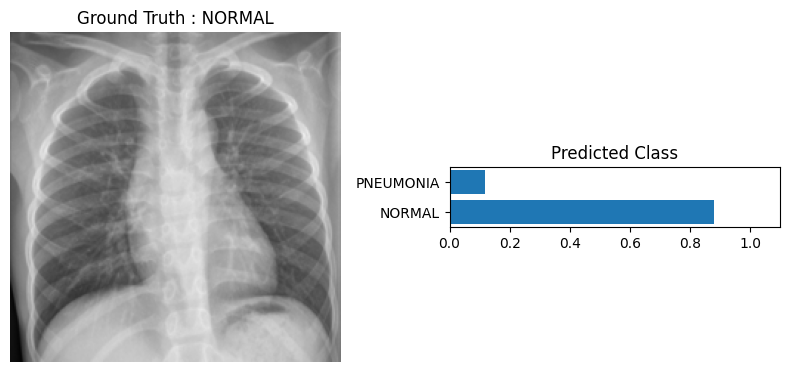

In [16]:
# Example
image, label = set_test[3]
logit = model(image.unsqueeze(0))
ps = F.softmax(logit, dim =1)
view_classify(image, ps, label)